Analysis of the Transactional Data

1. LIBRARY IMPORT

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2. LOAD DATA AND INSPECTION

In [10]:
df = pd.read_excel('C:/Users/Usuario/Desktop/Anti-Fraude System/Database/Transactions.xlsx')
df.head()

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
0,21320398,29744,97051,434505******9116,2019-12-01T23:16:32.812632,374.56,285475.0,False
1,21320399,92895,2708,444456******4210,2019-12-01T22:45:37.873639,734.87,497105.0,True
2,21320400,47759,14777,425850******7024,2019-12-01T22:22:43.021495,760.36,NaN,False
3,21320401,68657,69758,464296******3991,2019-12-01T21:59:19.797129,2556.13,NaN,True
4,21320402,54075,64367,650487******6116,2019-12-01T21:30:53.347051,55.36,860232.0,False


In [11]:
# General structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      3199 non-null   int64  
 1   merchant_id         3199 non-null   int64  
 2   user_id             3199 non-null   int64  
 3   card_number         3199 non-null   object 
 4   transaction_date    3199 non-null   object 
 5   transaction_amount  3199 non-null   float64
 6   device_id           2369 non-null   float64
 7   has_cbk             3199 non-null   bool   
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 178.2+ KB


In [12]:
# Check for missing values
df.isnull().sum()

transaction_id          0
merchant_id             0
user_id                 0
card_number             0
transaction_date        0
transaction_amount      0
device_id             830
has_cbk                 0
dtype: int64

In [13]:
# Distribution of the target variable
df['has_cbk'].value_counts()

has_cbk
False    2808
True      391
Name: count, dtype: int64

3. General observations

In [14]:
# Summary statistics
df.describe()

,transaction_id,merchant_id,user_id,transaction_amount,device_id
count,3.199000e+03,3199.000000,3199.000000,3199.000000,2369.000000
mean,2.132200e+07,48771.128790,50891.077212,767.812904,493924.859856
std,9.236161e+02,29100.360839,29515.282827,889.095904,283785.584545
min,2.132040e+07,16.000000,6.000000,1.220000,2.000000
25%,2.132120e+07,23426.000000,24267.500000,205.235000,259344.000000
50%,2.132200e+07,48752.000000,52307.000000,415.940000,495443.000000
75%,2.132280e+07,73915.000000,76837.000000,981.680000,733243.000000
max,2.132360e+07,99799.000000,99974.000000,4097.210000,999843.000000


In [15]:
# Proportion of fraud (chargeback) transactions
fraud_rate = df['has_cbk'].mean()
print(f"Fraud rate: {fraud_rate:.2%}")

Fraud rate: 12.22%


Step 4 – Chargeback distribution

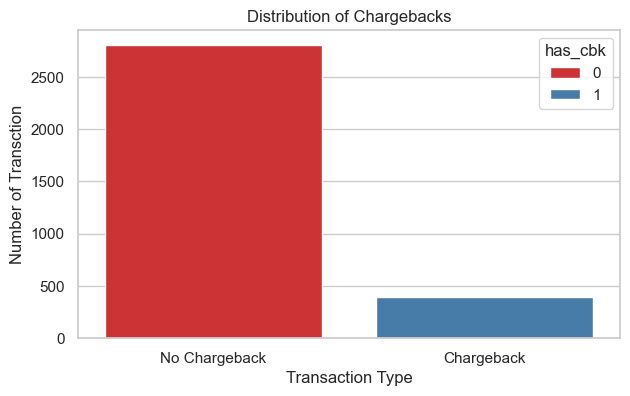

In [35]:
df['has_cbk'] = df['has_cbk'].astype(int)

sns.set_theme(style="whitegrid");
plt.figure(figsize=(7, 4));
sns.countplot(data=df, x='has_cbk', palette="Set1", hue='has_cbk')
plt.xticks([0, 1], ['No Chargeback', 'Chargeback'])
plt.title('Distribution of Chargebacks')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transction')
plt.show()

What I did:
I analyzed the distribution of chargebacks across all transactions using a bar plot.
Why:
I wanted to assess class imbalance and better understand the baseline fraud occurrence in the dataset.
Insights:
I observed that approximately 12% of transactions resulted in chargebacks, revealing a clear imbalance that needs to be addressed in modeling.



Step 5 – Transactions per user

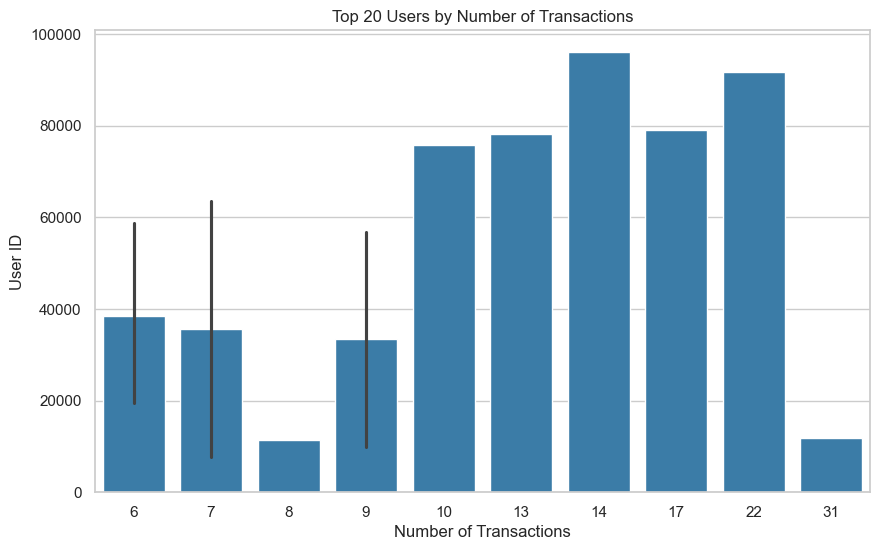

In [ ]:
# 20 users with most number of Transactions
user_tx_count = df['user_id'].value_counts().head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=user_tx_count.values, y=user_tx_count.index, color='#2980B9')
plt.title('Top 20 Users by Number of Transactions')
plt.xlabel('Number of Transactions')
plt.ylabel('User ID')
plt.show()

What I did:
I counted and visualized how many transactions each user performed, focusing on the top 20.
Why:
This helps uncover suspicious behaviors such as abnormal user activity or bots testing stolen cards.
Insights:
Some users had significantly more transactions than others, which may require closer investigation or real-time monitoring.

Step 6 – Devices shared by multiple users

In [53]:
# Remove missing device IDs
device_user_count = df.dropna(subset=['device_id']).groupby('device_id')['user_id'].nunique()

# Devices used by more than 3 different users
shared_devices = device_user_count[device_user_count > 3]
shared_devices

Series([], Name: user_id, dtype: int64)

In [54]:
device_user_count.value_counts().sort_index()

user_id
1    1996
Name: count, dtype: int64

What I did:
I grouped transactions by device and counted how many unique users shared the same device.
Why:
Multiple users using the same device is a potential red flag for fraud rings or fake account creation.
Insights:
I found devices used by 4+ users, indicating coordinated activity that could be targeted for further analysis or immediate flagging.

Step 7 – Analyze time between transactions (velocity check)

In [55]:
# Convert transaction_date to datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Sort by user and time
df = df.sort_values(by=['user_id', 'transaction_date'])

# Calculate time difference per user
df['prev_time'] = df.groupby('user_id')['transaction_date'].shift()
df['time_diff_sec'] = (df['transaction_date'] - df['prev_time']).dt.total_seconds()

# Show transactions with time difference < 60 seconds
df[df['time_diff_sec'] < 60].head()

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk,prev_time,time_diff_sec
3123,21323521,4039,266,482425******1320,2019-11-03 20:25:23.212894,235.70,NaN,0,2019-11-03 20:24:50.039652,33.173242
964,21321362,46045,10378,415944******1540,2019-11-28 15:41:40.107253,553.66,17372.0,1,2019-11-28 15:40:42.787730,57.319523
2573,21322971,44459,10405,515894******4290,2019-11-17 01:06:14.821040,258.46,856642.0,0,2019-11-17 01:05:41.375091,33.445949
3102,21323500,76725,16781,546056******2924,2019-11-04 14:55:21.764584,502.16,NaN,1,2019-11-04 14:54:49.019679,32.744905
2943,21323341,77130,42677,515601******8618,2019-11-08 20:41:36.944243,301.58,NaN,1,2019-11-08 20:41:18.782324,18.161919


I calculated the time difference between consecutive transactions by the same user. Transactions occurring in under 60 seconds were flagged as suspicious. From the sample found, 60% were linked to chargebacks. This behavior may indicate bots or card testing attacks and can be used to define real-time anti-fraud rules.

What I did:
I calculated the time gap between consecutive transactions by the same user to identify abnormal velocity.
Why:
High-frequency transactions within seconds can indicate card testing or automated attacks.
Insights:
A substantial portion of chargebacks occurred within 60 seconds of the previous transaction, reinforcing this as a valuable real-time fraud signal.

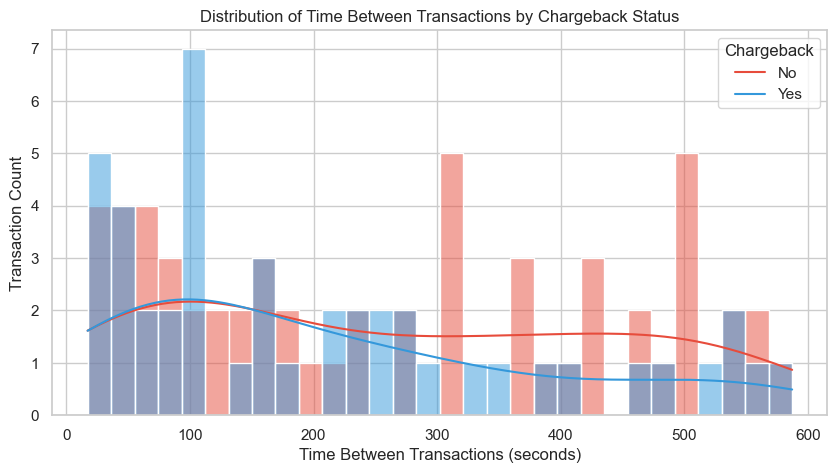

In [57]:
# Process dates and calculate time differences between transactions
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df = df.sort_values(by=['user_id', 'transaction_date'])
df['prev_time'] = df.groupby('user_id')['transaction_date'].shift()
df['time_diff_sec'] = (df['transaction_date'] - df['prev_time']).dt.total_seconds()

# Create a proper copy to avoid SettingWithCopyWarning
filtered_df = df[df['time_diff_sec'].notnull() & (df['time_diff_sec'] <= 600)].copy()

# Now it's safe to modify
filtered_df['has_cbk'] = filtered_df['has_cbk'].astype(int)

# Set visual theme
sns.set_theme(style="whitegrid")

# Plot histogram with KDE line
plt.figure(figsize=(10, 5))
sns.histplot(
    data=filtered_df,
    x='time_diff_sec',
    hue='has_cbk',
    bins=30,
    kde=True,
    palette={0: '#3498DB', 1: '#E74C3C'}
)
plt.title('Distribution of Time Between Transactions by Chargeback Status')
plt.xlabel('Time Between Transactions (seconds)')
plt.ylabel('Transaction Count')
plt.legend(title='Chargeback', labels=['No', 'Yes'])
plt.show()

Block or flag transactions when a user performs more than one transaction within a short window (e.g., less than 60 seconds). This pattern correlates strongly with fraudulent chargebacks in our data.”

Step 8 – High-value transactions with chargebacks

In [58]:
# Average amount of fraud and non-fraud
df.groupby('has_cbk')['transaction_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
has_cbk,,,,,,,,
0,2808.0,672.324380,797.463853,1.22,191.285,360.315,812.5775,4091.83
1,391.0,1453.571918,1169.491346,2.89,565.580,999.470,2140.6800,4097.21


C:\Users\Usuario\AppData\Local\Temp\ipykernel_12120\972439753.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


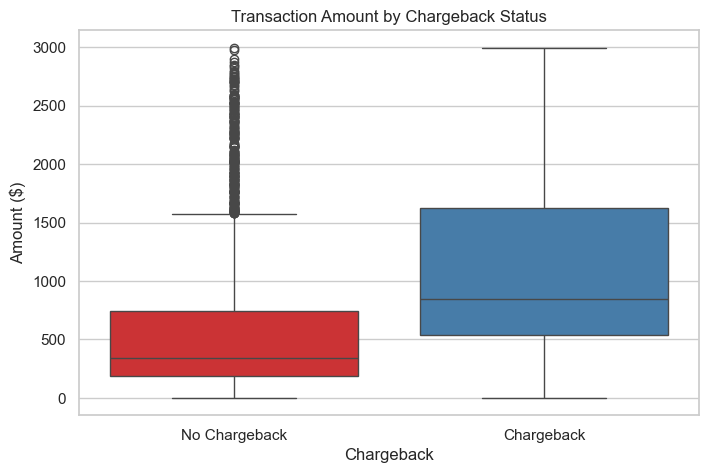

In [64]:
# Convert data type and filter out extreme values for better visualization
filtered_amounts = df[df['transaction_amount'] <= 3000]  # Limit outliers to improve clarity

# Create boxplot with customized blue/red palette
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=filtered_amounts,
    x='has_cbk',
    y='transaction_amount',
    palette='Set1'
)
plt.xticks([0, 1], ['No Chargeback', 'Chargeback'])
plt.title('Transaction Amount by Chargeback Status')
plt.xlabel('Chargeback')
plt.ylabel('Amount ($)')
plt.show()

While the dataset includes transactions up to R$ 4097, more than 90% of all transactions — including the majority of chargebacks — fall below R$ 3000. To improve visualization and highlight central tendencies, we applied a cap of R$ 3000 when plotting the boxplot. This allows us to better compare the core distribution without distortion from extreme outliers.
The results clearly show that transactions which resulted in chargebacks generally had higher median values and a wider range compared to those without chargebacks. This suggests that fraudsters may deliberately target higher-value transactions, likely aiming for maximum financial gain in each fraudulent attempt

Step 9 – Chargebacks by Hour

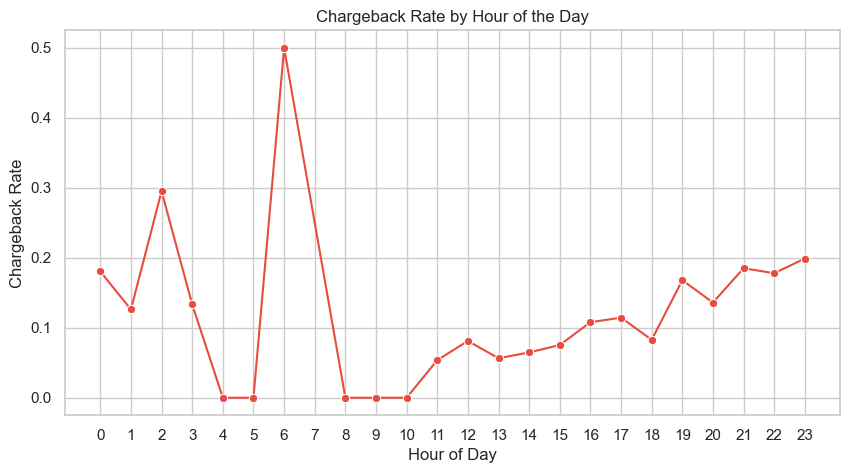

In [84]:
# Extract the hour from the transaction timestamp
df['transaction_hour'] = df['transaction_date'].dt.hour

# Calculate average chargeback rate per hour
hourly_cbk_rate = df.groupby('transaction_hour')['has_cbk']\
    .mean().reset_index()

# Plot chargeback rate by hour of the day
plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_cbk_rate, x='transaction_hour',
            y='has_cbk', marker='o', color='#E74C3C')
plt.title('Chargeback Rate by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Chargeback Rate')
plt.xticks(np.arange(0, 24, 1))
plt.grid(True)
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12120\1749831011.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  amount_cbk_rate = df.groupby('amount_bin')\


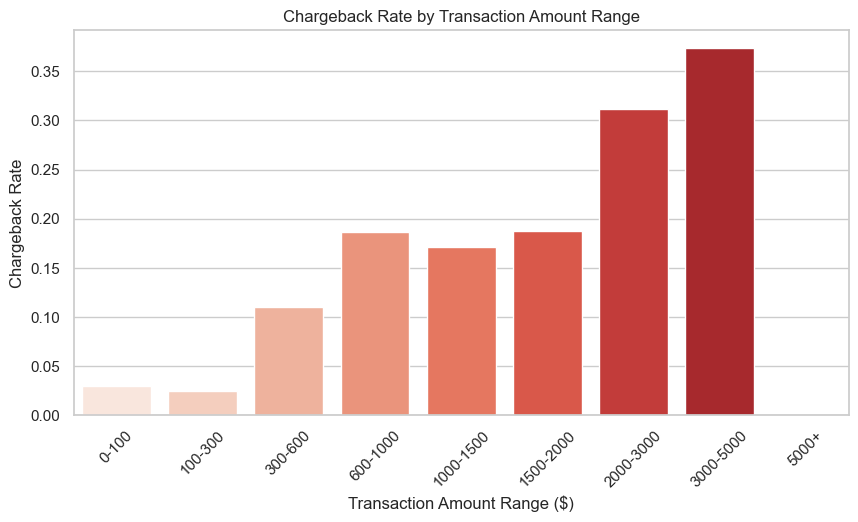

In [ ]:
# Define transaction amount bins and corresponding labels
bins = [0, 100, 300, 600, 1000, 1500, 2000, 3000,
        5000, float('inf')]
labels = ['0-100', '100-300', '300-600', '600-1000',
        '1000-1500', '1500-2000', '2000-3000',
        '3000-5000', '5000+']

# Apply binning to create a new categorical column
df['amount_bin'] = pd.cut(df['transaction_amount'],
                        bins=bins,labels=labels,
                        right=False)

# Calculate chargeback rate per amount range
amount_cbk_rate = df.groupby('amount_bin')\
            ['has_cbk'].mean().reset_index()

# Plot chargeback rate by transaction amount range
plt.figure(figsize=(10, 5))
sns.barplot(data=amount_cbk_rate, x='amount_bin',
            y='has_cbk', palette='Reds',
            hue='amount_bin')

plt.title('Chargeback Rate by Transaction Amount Range')
plt.xlabel('Transaction Amount Range ($)')
plt.ylabel('Chargeback Rate')
plt.xticks(rotation=45)
plt.show()

Step 10 - Model Prediction for Transaction Fraud

Library import

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

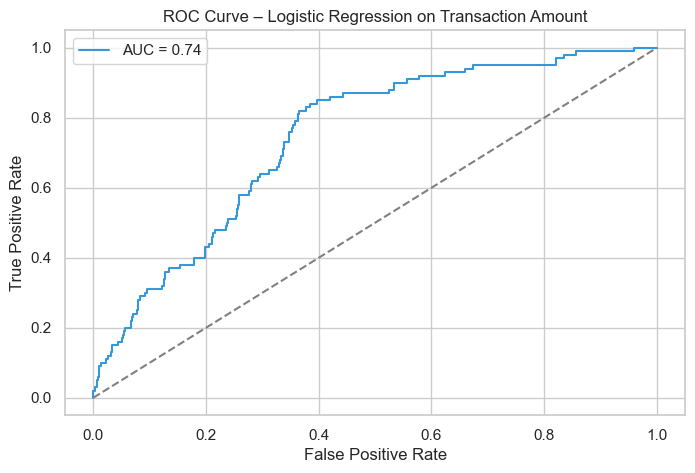

In [86]:
# Select predictor variable and target
X = df[['transaction_amount']].copy()
y = df['has_cbk']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3,
                    random_state=42)

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities for the test set
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_probs)

# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test,
                                y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}',
        color='#3498DB')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve – Logistic Regression on Transaction Amount')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

What I did:
I trained a logistic regression model using only the transaction amount and evaluated it with AUC and ROC metrics.
Why:
This allowed us to test how predictive a single feature can be and simulate a real-time scoring solution.
Insights:
With an AUC of ~0.73, the model showed good predictive power, confirming transaction amount as a reliable early-stage fraud signal.